# Bike Sharing Assignment

<b>Aim</b>:<br>
To build a model that estimates the demand for shared bikes using which demand dynamics can be understood and business strategy can be modified accordingly.

## Reading the Data

In [1757]:
#libraries Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import chardet
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Setting warnings to be ignored
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{0:,.2f}'.format

In [1758]:
#Detecting the encoding type
with open("day.csv", 'rb') as rawdata:
    enconding_type = chardet.detect(rawdata.read(1000))['encoding']
    print("day.csv encoding type is" ,enconding_type)

day.csv encoding type is ascii


In [1759]:
df_bike_share = pd.read_csv("day.csv",encoding=enconding_type)
df_bike_share.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.11,18.18,80.58,10.75,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.90,17.69,69.61,16.65,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.05,9.47,43.73,16.64,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.20,10.61,59.04,10.74,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.31,11.46,43.70,12.52,82,1518,1600


In [1760]:
#Shape of the dataframe
df_bike_share.shape

(730, 16)

In [1761]:
#describe the dataframe
df_bike_share.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00
mean,365.50,2.50,0.50,6.53,0.03,3.00,0.68,1.39,20.32,23.73,62.77,12.76,849.25,"3,658.76","4,508.01"
std,210.88,1.11,0.50,3.45,0.17,2.01,0.47,0.54,7.51,8.15,14.24,5.20,686.48,"1,559.76","1,936.01"
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,2.42,3.95,0.00,1.50,2.00,20.00,22.00
25%,183.25,2.00,0.00,4.00,0.00,1.00,0.00,1.00,13.81,16.89,52.00,9.04,316.25,"2,502.25","3,169.75"
50%,365.50,3.00,0.50,7.00,0.00,3.00,1.00,1.00,20.47,24.37,62.62,12.13,717.00,"3,664.50","4,548.50"
75%,547.75,3.00,1.00,10.00,0.00,5.00,1.00,2.00,26.88,30.45,72.99,15.63,"1,096.50","4,783.25","5,966.00"
max,730.00,4.00,1.00,12.00,1.00,6.00,1.00,3.00,35.33,42.04,97.25,34.00,"3,410.00","6,946.00","8,714.00"


## Data Cleaning and Data Understanding

As our aim is to predict the demand for shared bikes we are going to predict the esitmates for target variable which is 'cnt' which as per data dicitonary<br>
- cnt: count of total rental bikes including both casual and registered<br>

So , cnt = casual + registered. As casual and registered derive the target variable , they donot add any value to our anaysis.So, we will be dropping them.<br>
<b>Note</b>:<br>
The same was mentioned during pre-assignment session which concluded that casual and registered variables have no value to the analysis.

In [1762]:
columns_tobe_dropped = set(["casual","registered"])

In [1763]:
#Inspecting null value percentages in the data frame
round((df_bike_share.isnull().sum()/len(df_bike_share.index))*100,2)

instant      0.00
dteday       0.00
season       0.00
yr           0.00
mnth         0.00
holiday      0.00
weekday      0.00
workingday   0.00
weathersit   0.00
temp         0.00
atemp        0.00
hum          0.00
windspeed    0.00
casual       0.00
registered   0.00
cnt          0.00
dtype: float64

As observed there are no null values found in the data frame

Let's inspect some of the categorical columns in the data frame.

After going through the data dictionary the following information was observed.

    - dteday : date 
        which is in dd-mm-yyyy format
	- yr : year (0: 2018, 1:2019)
    - mnth : month ( 1 to 12)
	- weekday : day of the week
    
It is clear that dteday can be explained by combination of weekday,month and year. So, the column dteday is not adding any value to the analysis. So , we will be dropping this column.

In [1764]:
columns_tobe_dropped.add("dteday")

The column instant is record index which doesn't play any roles in our analysis so we will drop it.     

In [1765]:
columns_tobe_dropped.add("instant")

After understanding the data dictionary we have found some columns which need to be mapped to their corresponding catgorical values.

As we will create dummy varaibles for these categorical variables we will add them to columns_tobe_dropped, so that they can be dropped in the future once dummy varaibles are created.

Inspecting <b>season</b> column:<br> 

As per data dictionary the numeric values mean the following

<b>season</b><br>

1:spring<br> 
2:summer<br>
3:fall<br>
4:winter<br>

So, we will perform mapping accordingly.

In [1766]:
#Inspecting the value_counts in season column
df_bike_share.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [1767]:
#Mapping to respective categorical values as per data dictionary
df_bike_share.season = df_bike_share.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

In [1768]:
df_bike_share.season.value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [1769]:
#Adding season to the columns_tobe_dropped set
columns_tobe_dropped.add("season")

Inspecting <b>weathersit</b> column:<br> 
As per data dictionary the numeric values mean the following<br>
<b>weathersit</b><br> 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [1770]:
#Inspecting the value_counts in weathersit column
df_bike_share.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

<b>Note</b>:<br>

1. weathersit column doesn't have numeric value 4 currently,So, when we map the corresponding categorical values with numeric values the column will have only 3 unique values.

2. The categorical strings used below for mapping were suggested to be used during live assignment session as the string values in data dict were really big. The descriptions refer to generalized meaning. So, using the same in mapping.

1: 'Clear'<br>
2: 'Mist + Cloudy'<br>
3: 'Light Rain or Snow'<br>
4: 'Heavy Rain or Snow'<br>

In [1771]:
#Mapping to respective categorical values as per data dictionary
df_bike_share.weathersit = df_bike_share.weathersit.map({1: 'Clear',
                              2: 'Mist + Cloudy',
                              3: 'Light Rain or Snow',
                              4: 'Heavy Rain or Snow'
                             })

In [1772]:
df_bike_share.weathersit.value_counts()

Clear                 463
Mist + Cloudy         246
Light Rain or Snow     21
Name: weathersit, dtype: int64

In [1773]:
#datatype of weathersit after mapping
df_bike_share.weathersit.dtype

dtype('O')

In [1774]:
#Adding weathersit to the columns_tobe_dropped set
columns_tobe_dropped.add("weathersit")

In [1775]:
#Inspecting mnth column
df_bike_share.mnth.value_counts() 

12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     56
Name: mnth, dtype: int64

In [1776]:
#Mapping to respective categorical values
df_bike_share.mnth = df_bike_share.mnth.map({
                              1: 'Jan',
                              2: 'Feb',
                              3: 'Mar',
                              4: 'Apr',
                              5: 'May',
                              6: 'Jun',
                              7: 'Jul',
                              8: 'Aug',
                              9: 'Sep',
                              10:'Oct',
                              11:'Nov',
                              12:'Dec'
                             })

In [1777]:
df_bike_share.mnth.value_counts() 

Mar    62
Aug    62
May    62
Jul    62
Dec    62
Jan    62
Oct    62
Apr    60
Jun    60
Nov    60
Sep    60
Feb    56
Name: mnth, dtype: int64

In [1778]:
#Adding mnth to the columns_tobe_dropped set
columns_tobe_dropped.add("mnth")

In [1779]:
#Inspecting weekday  column
df_bike_share.weekday.value_counts()

6    105
1    105
0    105
5    104
4    104
2    104
3    103
Name: weekday, dtype: int64

Mapping with following data<br>
                              0: 'Sun'<br>
                              1: 'Mon'<br>
                              2: 'Tue'<br>
                              3: 'Wed'<br>
                              4: 'Thu'<br>
                              5: 'Fri'<br>
                              6: 'Sat'<br>
<b>Note</b>:
It was found that the mapping in data starts from 0-Tue and so on. This was mentioned during a live session and the above mapping was suggested to be used , so using the same.

In [1780]:
#Mapping to respective categorical values
df_bike_share.weekday = df_bike_share.weekday.map({
                              0: 'Sun',
                              1: 'Mon',
                              2: 'Tue',
                              3: 'Wed',
                              4: 'Thu',
                              5: 'Fri',
                              6: 'Sat'
                             })

In [1781]:
df_bike_share.weekday.value_counts()

Mon    105
Sat    105
Sun    105
Tue    104
Thu    104
Fri    104
Wed    103
Name: weekday, dtype: int64

In [1782]:
#Adding weekday to the columns_tobe_dropped set
columns_tobe_dropped.add("weekday")

In [1783]:
df_bike_share.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,Jan,0,Sat,0,Mist + Cloudy,14.11,18.18,80.58,10.75,331,654,985
1,2,02-01-2018,spring,0,Jan,0,Sun,0,Mist + Cloudy,14.90,17.69,69.61,16.65,131,670,801
2,3,03-01-2018,spring,0,Jan,0,Mon,1,Clear,8.05,9.47,43.73,16.64,120,1229,1349
3,4,04-01-2018,spring,0,Jan,0,Tue,1,Clear,8.20,10.61,59.04,10.74,108,1454,1562
4,5,05-01-2018,spring,0,Jan,0,Wed,1,Clear,9.31,11.46,43.70,12.52,82,1518,1600


## Visualising the Data

#### Visualising Numeric Variables
We will visualize some numeric varaibles to check to if there exists a linear relationship with our target variables cnt.<br>
We will be using a pair plot for this.

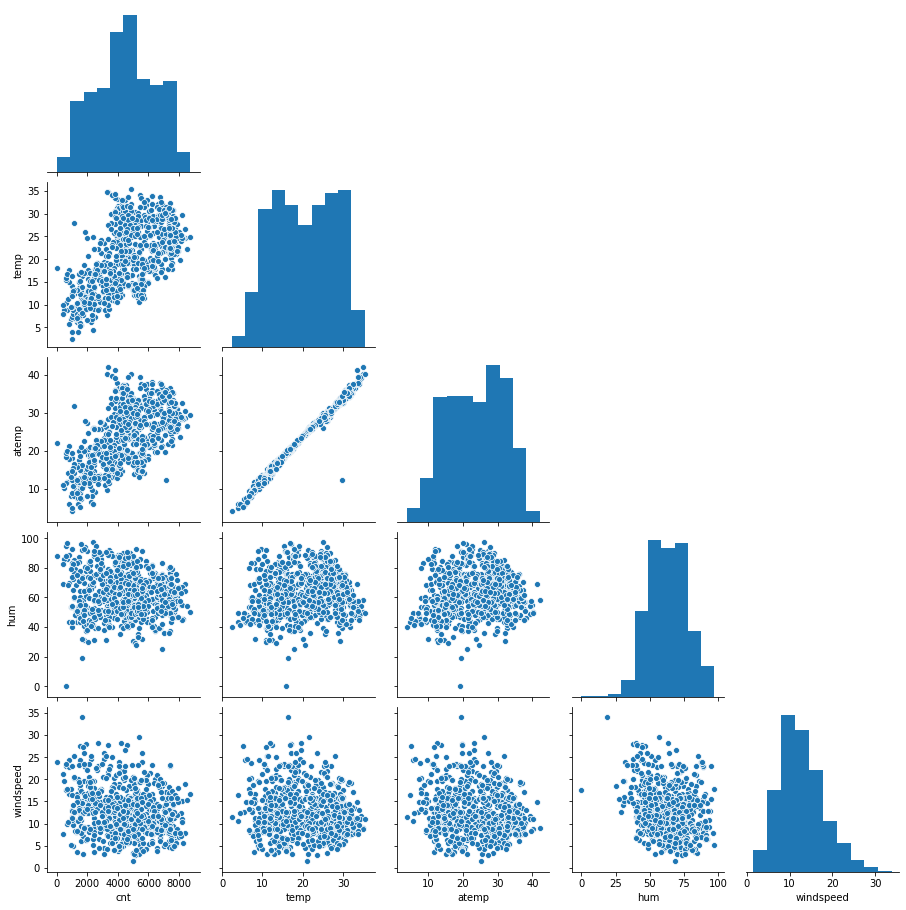

In [1784]:
sns.pairplot(df_bike_share[['cnt','temp','atemp','hum','windspeed']],corner=True)
plt.show()

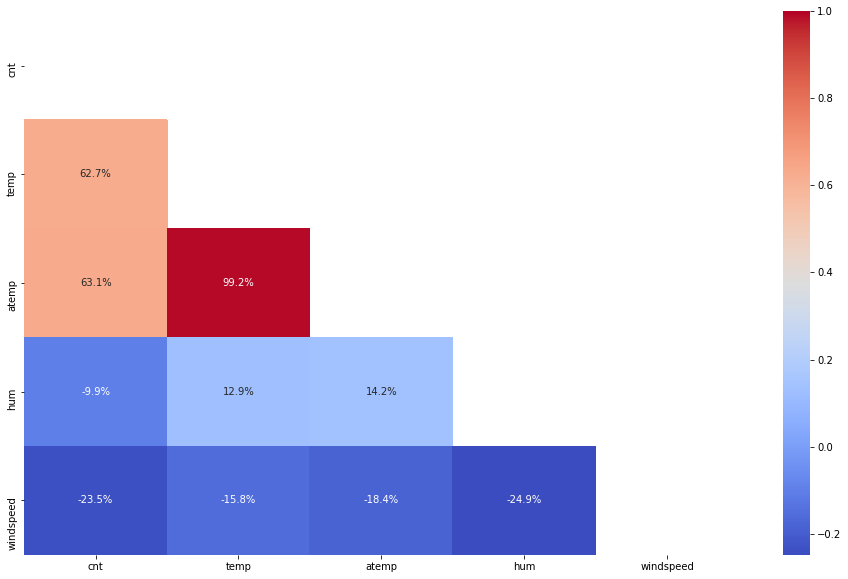

In [1785]:
plt.figure(figsize = (16, 10))
mask_ut=np.triu(np.ones(df_bike_share[['cnt','temp','atemp','hum','windspeed']].corr(method='spearman').shape)).astype(np.bool)
sns.heatmap(df_bike_share[['cnt','temp','atemp','hum','windspeed']].corr(),mask=mask_ut, annot = True, cmap="coolwarm",fmt='.1%')
plt.show()

We can clearly see that variables cnt has linear relationship with some varaibles in the data frame. So, we can use Multiple Linear regression to build a model using this data set.

#### Visualising Categorical Variables

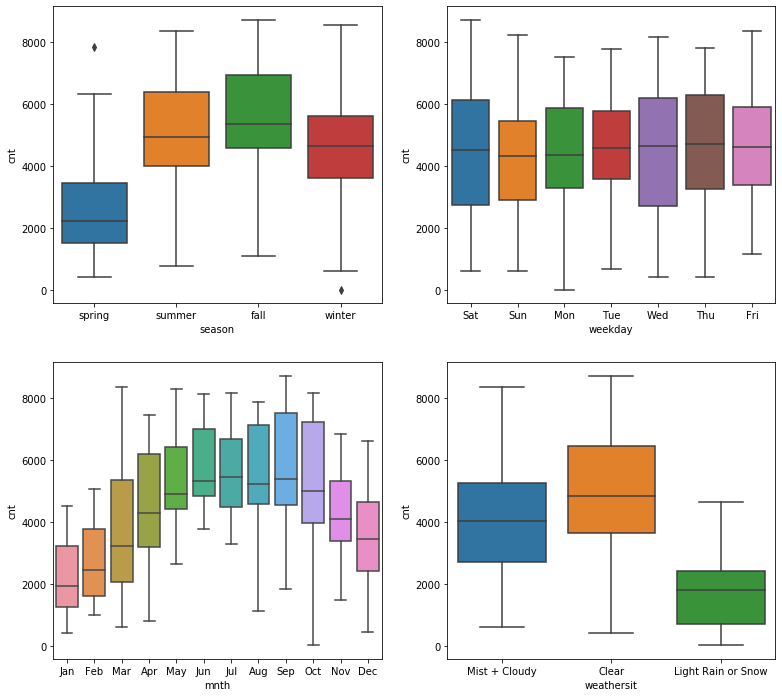

In [1786]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df_bike_share)
plt.subplot(2,3,2)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_bike_share)
plt.subplot(2,3,4)
sns.boxplot(x = 'mnth', y = 'cnt', data = df_bike_share)
plt.subplot(2,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df_bike_share)
plt.show()

## Dummy Variable Creation

In [1787]:
#Creating dummy variables from the categorical variable season
season_dummies = pd.get_dummies(df_bike_share.season, drop_first = True)
season_dummies.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [1788]:
#Concating the dummies with main bike share data frame
df_bike_share = pd.concat([df_bike_share, season_dummies], axis = 1)

In [1789]:
#Creating dummy variables from the categorical variable weathersit
weathersit_dummies = pd.get_dummies(df_bike_share.weathersit, drop_first = True)
weathersit_dummies.head()

,Light Rain or Snow,Mist + Cloudy
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [1790]:
#Concating the dummies with main bike share data frame
df_bike_share = pd.concat([df_bike_share, weathersit_dummies], axis = 1)

In [1791]:
#Creating dummy variables from the categorical variable weekday
weekday_dummies = pd.get_dummies(df_bike_share.weekday, drop_first = True)
weekday_dummies.head()

,Mon,Sat,Sun,Thu,Tue,Wed
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1


In [1792]:
#Concating the dummies with main bike share data frame
df_bike_share = pd.concat([df_bike_share, weekday_dummies], axis = 1)

In [1793]:
#Creating dummy variables from the categorical variable mnth
mnth_dummies = pd.get_dummies(df_bike_share.mnth, drop_first = True)
mnth_dummies.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [1794]:
#Concating the dummies with main bike share data frame
df_bike_share = pd.concat([df_bike_share, mnth_dummies], axis = 1)

In [1795]:
#Dropping all columns which have been determined to be dropped till now
print("Dropping the following columns ", columns_tobe_dropped)
df_bike_share.drop(list(columns_tobe_dropped), axis = 1, inplace = True)
df_bike_share.shape

Dropping the following columns  {'weathersit', 'weekday', 'registered', 'casual', 'season', 'dteday', 'instant', 'mnth'}


(730, 30)

 ## Splitting the Data into Training and Testing Sets

We will be following 70-30 split train-test ratio during the splitting.

In [1796]:
df_train, df_test = train_test_split(df_bike_share, train_size = 0.7, test_size = 0.3, random_state = 100)
print("Train data shape", df_train.shape)
print("Test data shape", df_test.shape)

Train data shape (510, 30)
Test data shape (219, 30)


## Scaling of Train data

We will be using min_max scaling which will bring all the numeric variabels on to a same scale.

In [1797]:
scaler = MinMaxScaler()

Applying scaling to all the numeric variables in train data set which are not in 0 to 1 range.

In [1798]:
num_vars = ['cnt','temp','atemp','hum','windspeed']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
653,1,0,1,0.51,0.50,0.58,0.30,0.86,0,0,...,0,0,0,0,0,0,0,0,1,0
576,1,0,1,0.82,0.77,0.73,0.26,0.83,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.44,0.44,0.64,0.26,0.47,1,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.25,0.20,0.50,0.66,0.20,1,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.40,0.39,0.50,0.19,0.48,0,1,...,0,0,0,0,0,0,0,0,0,0


In [1799]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,510.00,510.00,510.00,510.00,510.00,510.00,510.00,510.00,510.00,510.00,...,510.00,510.00,510.00,510.00,510.00,510.00,510.00,510.00,510.00,510.00
mean,0.51,0.03,0.68,0.54,0.51,0.65,0.32,0.51,0.24,0.25,...,0.08,0.07,0.09,0.08,0.07,0.10,0.08,0.09,0.09,0.08
std,0.50,0.16,0.47,0.23,0.21,0.15,0.17,0.22,0.43,0.43,...,0.28,0.25,0.28,0.27,0.26,0.30,0.28,0.28,0.28,0.27
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.34,0.33,0.54,0.20,0.36,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,0.00,1.00,0.54,0.53,0.65,0.30,0.52,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,0.00,1.00,0.74,0.69,0.75,0.41,0.68,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Dividing into X and Y sets for the model building

In [1800]:
y_train = df_train.pop('cnt') #Target variable
X_train = df_train

## Building our model

In [1801]:
len(X_train.columns)

29

As there are 29 data varaibles , we will Recursive feature elimination to find the top 10 variables and perform manual feature elimination from there.

In [1802]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 10)
rfe = rfe.fit(X_train, y_train)

In [1803]:
col = X_train.columns[rfe.support_]
print("The top 10 variables are ")
col.values

The top 10 variables are 


array(['yr', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'spring',
       'Light Rain or Snow', 'Jul', 'Oct'], dtype=object)

In [1804]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1805]:
#Creating a function for model builiding
def build_model(y,X):
        X = sm.add_constant(X) #Adding constant as we are using stats model
        lm = sm.OLS(y,X).fit()
        print(lm.summary())
        return lm

In [1806]:
#Creating a function for VIF Calculation
def get_VIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [1807]:
lm = build_model(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     230.1
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          1.03e-179
Time:                        22:32:43   Log-Likelihood:                 478.28
No. Observations:                 510   AIC:                            -934.6
Df Residuals:                     499   BIC:                            -888.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4228      0

In [1808]:
get_VIF(X_train_rfe)

,Features,VIF
3,atemp,346.82
2,temp,338.99
4,hum,11.55
5,windspeed,3.98
0,yr,2.03
6,spring,1.88
8,Jul,1.36
9,Oct,1.20
7,Light Rain or Snow,1.13
1,holiday,1.03


From the above statictis atemp has high VIF 346.82 and high p-value 0.278. So, we are going to drop the column.

In [1809]:
X_train_rfe = X_train_rfe.drop('atemp', 1)

In [1810]:
#Rebudilding the model with the modified data frame
lm = build_model(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     255.4
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          1.13e-180
Time:                        22:32:44   Log-Likelihood:                 477.68
No. Observations:                 510   AIC:                            -935.4
Df Residuals:                     500   BIC:                            -893.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4264      0

In [1811]:
get_VIF(X_train_rfe)

,Features,VIF
3,hum,11.00
2,temp,10.51
4,windspeed,3.90
0,yr,2.03
5,spring,1.88
7,Jul,1.36
8,Oct,1.20
6,Light Rain or Snow,1.12
1,holiday,1.03


From the above we can see that hum has high VIF value 11.00 . So , we will be dropping the variable.

In [1812]:
X_train_rfe = X_train_rfe.drop('hum', 1)

In [1813]:
lm = build_model(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     249.3
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          2.87e-169
Time:                        22:32:44   Log-Likelihood:                 447.95
No. Observations:                 510   AIC:                            -877.9
Df Residuals:                     501   BIC:                            -839.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2515      0

In [1814]:
get_VIF(X_train_rfe)

,Features,VIF
2,temp,3.99
3,windspeed,3.75
0,yr,2.03
4,spring,1.52
6,Jul,1.27
7,Oct,1.14
5,Light Rain or Snow,1.07
1,holiday,1.03


From the above data we have observe that 
1. There are no high VIF values(i.e. > 5).
2. All the p-values are with in the significance level (0.05).
3. R-Squared value of 0.799 is good.
4. Low value of Prob (F-statistic) conveys that our model is good fit.

In [1815]:
#So the predictor variables for our model are 
predictor_columns = X_train_rfe.columns
predictor_columns

Index(['yr', 'holiday', 'temp', 'windspeed', 'spring', 'Light Rain or Snow',
       'Jul', 'Oct'],
      dtype='object')

In [1816]:
#Co-efficeints
print("The co-efficients of our regression model are ")
lm.params

The co-efficients of our regression model are 


const                 0.25
yr                    0.24
holiday              -0.07
temp                  0.43
windspeed            -0.15
spring               -0.13
Light Rain or Snow   -0.25
Jul                  -0.07
Oct                   0.05
dtype: float64

## Residual Analysis of the train data

To verify the assumptions of Multi linear regression , we will be performing residual analysis on train data.

The assumptions are 

<b>Multivariate Normality</b><br>
<b>No Multicollinearity</b><br>
<b>Homoscedasticity</b><br>

No Multicollinearity has been determined by using the VIF values in previous steps.

In [1817]:
X_train_res = sm.add_constant(X_train_rfe)

In [1818]:
#Predicting on the train data using the final model
y_train_cnt = lm.predict(X_train_res)

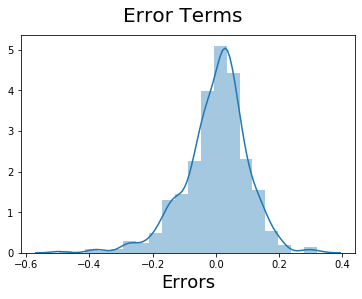

In [1819]:
#Plotting the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)     
plt.show()

It's observed from the above graph that Error Terms are Normally distributed around 0 and variance of distribution is constant.

## Making Predictions Using the Final Model

## Scaling on Test data

We already have the scaler which was used in train data. Here we will use the same scaler but we ware going to only transform 
the test data.

In [1820]:
num_vars = ['cnt','temp','atemp','hum','windspeed']
df_test[num_vars] = scaler.transform(df_test[num_vars]) # Only Transform
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
184,0,1,0,0.83,0.77,0.66,0.08,0.69,0,0,...,0,0,0,1,0,0,0,0,0,0
535,1,0,1,0.90,0.84,0.61,0.15,0.71,0,1,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.51,0.50,0.84,0.33,0.30,0,0,...,0,0,0,0,0,0,0,0,1,0
221,0,0,1,0.88,0.80,0.44,0.34,0.55,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.82,0.74,0.31,0.54,0.57,0,1,...,0,0,0,0,1,0,0,0,0,0


In [1821]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,...,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00
mean,0.48,0.04,0.70,0.56,0.53,0.64,0.31,0.52,0.26,0.26,...,0.09,0.10,0.08,0.11,0.10,0.05,0.09,0.07,0.08,0.09
std,0.50,0.19,0.46,0.23,0.22,0.15,0.16,0.22,0.44,0.44,...,0.28,0.30,0.27,0.31,0.30,0.23,0.28,0.26,0.28,0.28
min,0.00,0.00,0.00,0.05,0.03,0.26,-0.04,0.05,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.35,0.34,0.53,0.20,0.38,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,1.00,0.56,0.55,0.63,0.30,0.52,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,0.00,1.00,0.76,0.71,0.74,0.40,0.67,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,0.98,0.98,1.00,0.81,0.96,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Dividing into X_test and y_test

In [1822]:
y_test = df_test.pop('cnt')
X_test = df_test[predictor_columns]

In [1823]:
# Adding constant variable to test dataframe
X_test_rfe = sm.add_constant(X_test)

In [1824]:
X_test_rfe.head()

,const,yr,holiday,temp,windspeed,spring,Light Rain or Snow,Jul,Oct
184,1.00,0,1,0.83,0.08,0,0,1,0
535,1.00,1,0,0.90,0.15,0,0,0,0
299,1.00,0,0,0.51,0.33,0,0,0,1
221,1.00,0,0,0.88,0.34,0,0,0,0
152,1.00,0,0,0.82,0.54,0,0,0,0


In [1825]:
# Making predictions using the final model
y_pred = lm.predict(X_test_rfe)

## Model Evaluation    

Text(0, 0.5, 'y_pred')

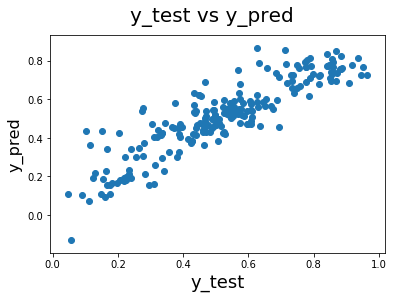

In [1826]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)

We can see that the equation for our best fitted model is <br> 
cnt =  0.24 * yr - 0.07 * holiday +  0.43 * temp - 0.15 * windspeed - 0.13 * spring - 0.25 * Light Rain or Snow - 0.07 * Jul + 0.05 * Oct + 0.25 <br>  
<br> 
Note:<br> 
Light Rain or Snow refers to weather situation - ‘Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds’.

In [1827]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.791897780391255